# Imports

In [1]:
# Standard library imports
import os
import random
import io
import zipfile
import warnings

# Third-party imports for data handling and computation
import pandas as pd
import numpy as np
import requests
from PIL import Image
from skimage import io as skimage_io

# Third-party imports for machine learning and image processing
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import timm

# Third-party imports for visualization and progress tracking
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_auto

# Third-party imports for advanced image transformations
from albumentations import (
    Compose, Resize, HorizontalFlip, RandomBrightnessContrast,
    ShiftScaleRotate, GridDistortion, ElasticTransform, RandomSizedCrop,
    Normalize
)
from albumentations.pytorch import ToTensorV2

# Set pandas display option and suppress warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')


/export/livia/home/vision/Mkdayem/nadhem/miniconda3/envs/myenv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/export/livia/home/vision/Mkdayem/nadhem/miniconda3/envs/myenv/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/export/livia/home/vision/Mkdayem/nadhem/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download Data

In [2]:
# def download_and_unzip_file(url, file_name):
#     """
#     Download a file from a given URL and saves it with the given file name.
#     If the file is a ZIP file, it will be unzipped into a directory with the same name.

#     Parameters:
#     url (str): URL of the file to download.
#     file_name (str): Name to save the file as.
#     """
#     response = requests.get(url)
#     if response.status_code == 200:
#         with open(file_name, 'wb') as f:
#             f.write(response.content)
#         print(f'{file_name} downloaded successfully.')

#         # Unzipping if it is a zip file
#         if file_name.endswith('.zip'):
#             zip_dir = file_name[:-4]  # Directory name (remove .zip)
#             with zipfile.ZipFile(file_name, 'r') as zip_ref:
#                 zip_ref.extractall(zip_dir)
#             print(f'{file_name} unzipped into directory: {zip_dir}')
#     else:
#         print(f'Failed to download {file_name}. Status code: {response.status_code}')

# # URLs and file names
# files_to_download = {
#     "https://api.zindi.africa/v1/competitions/gods-30/files/data.zip?auth_token=zus.v1.mWS83W2.sWoGyFBL4VNH3BRAEqkXv1DYyi984o": "data.zip",
#     "https://api.zindi.africa/v1/competitions/gods-30/files/Variable%20Definitions.csv?auth_token=zus.v1.mWS83W2.sWoGyFBL4VNH3BRAEqkXv1DYyi984o": "variabledefinitions.csv",
# }

# # Download and unzip each file
# for url, file_name in files_to_download.items():
#     download_and_unzip_file(url, file_name)


# Fix SEED

In [3]:
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Ensure reproducibility
random_state = 42
generator = torch.Generator().manual_seed(random_state)

seed_everything(SEED)

In [4]:
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")
# vd = pd.read_csv("/kaggle/working/variabledefinitions.csv")


# Exploratory Data Analysis

## Image Vizualization

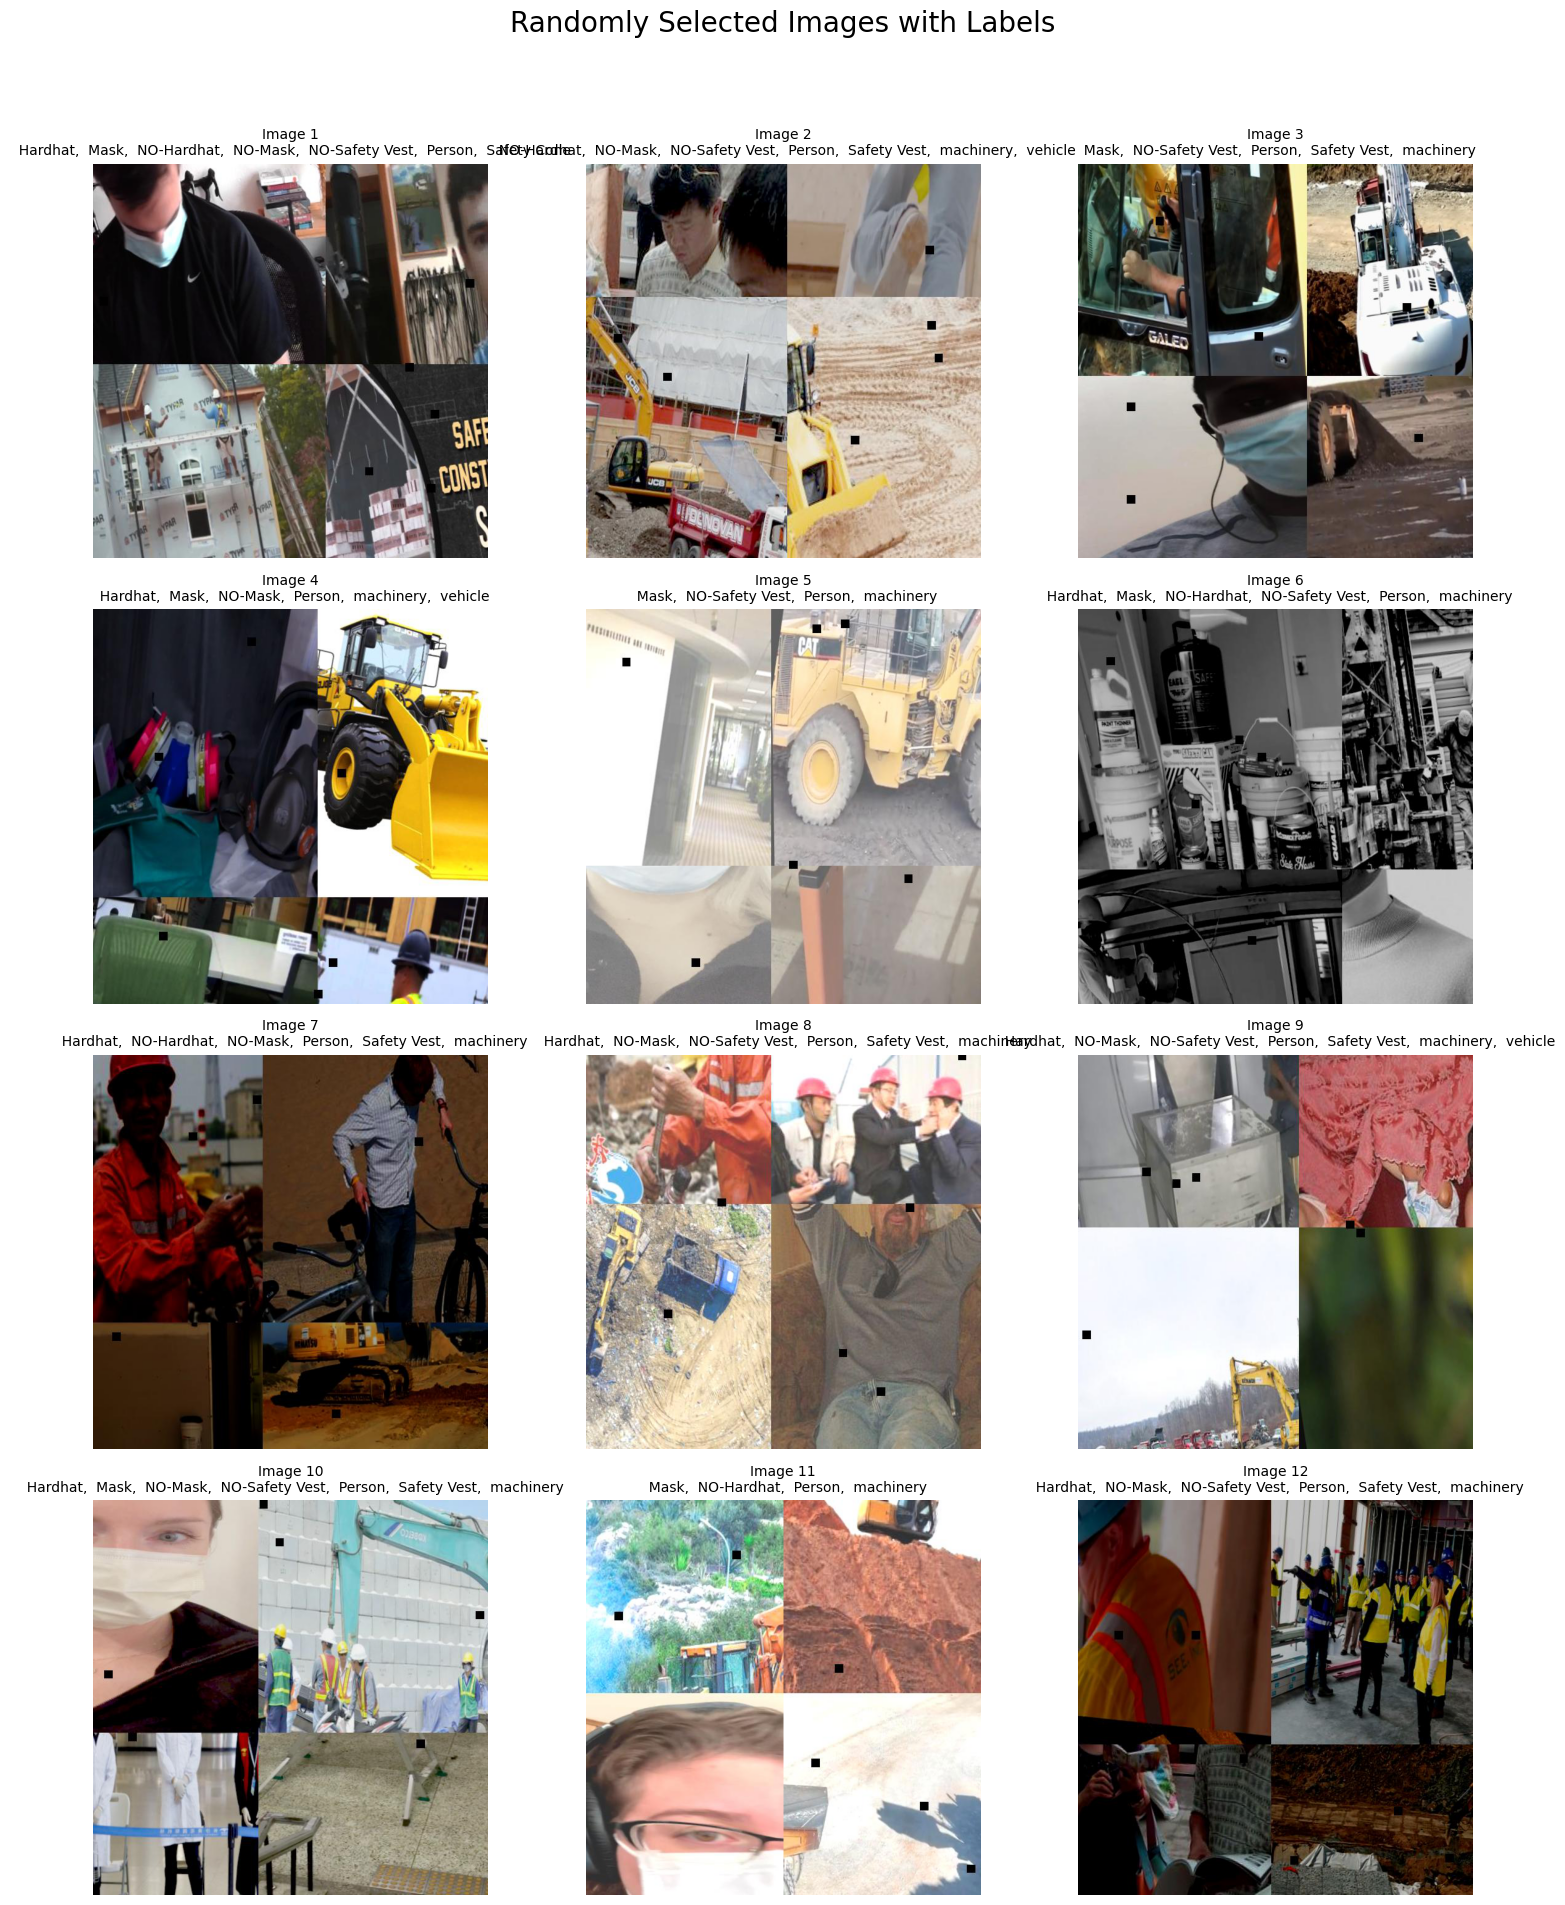

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import random

directory_path = '/export/livia/home/vision/Mkdayem/nadhem/miniconda3/envs/myenv/data/train'  # Replace with your actual directory path

# Select 12 random images
sample_df = train_df.sample(12, random_state=1)

# Plotting in a 4x3 grid with larger images
fig, axs = plt.subplots(4, 3, figsize=(15, 20))  # Adjusted size for a 4x3 grid
fig.suptitle('Randomly Selected Images with Labels', fontsize=20)

for i, (idx, row) in enumerate(sample_df.iterrows()):
    img_path = os.path.join(directory_path, row['filename'])
    img = Image.open(img_path)
    labels = ', '.join([col for col in train_df.columns[1:] if row[col] == 1])

    ax = axs[i // 3, i % 3]  # Adjusted for a 4x3 grid
    ax.imshow(img)
    ax.set_title(f'Image {i+1}\n {labels}', fontsize=10)
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Distribution of Labels

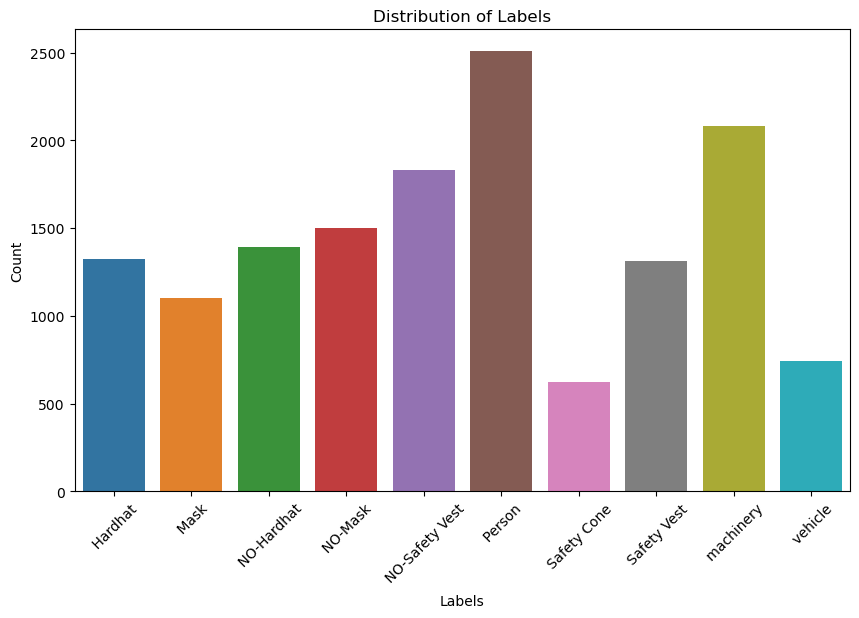

In [6]:
import seaborn as sns

label_columns = train_df.columns[1:]  
label_distribution = train_df[label_columns].sum()

# Plotting label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_distribution.index, y=label_distribution.values)
plt.title('Distribution of Labels')
plt.ylabel('Count')
plt.xlabel('Labels')
plt.xticks(rotation=45)
plt.show()

## Correlation between Labels

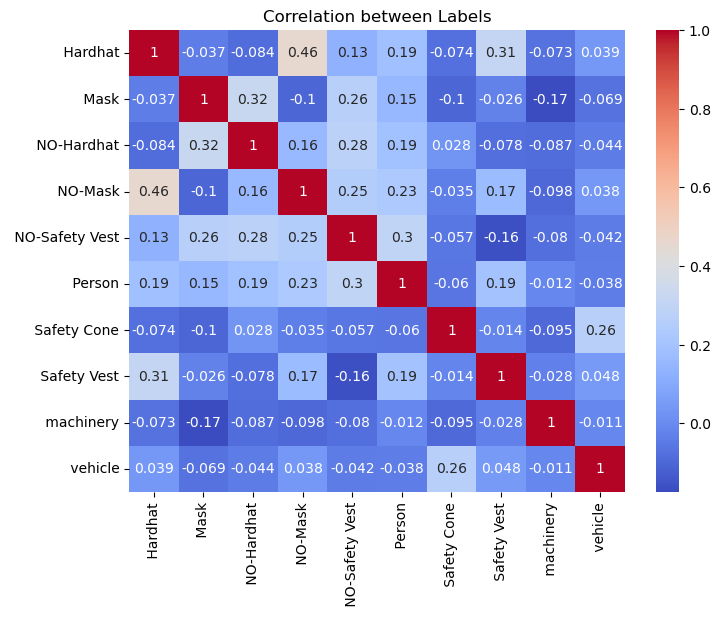

In [7]:
label_correlation = train_df[label_columns].corr()

# Plotting correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(label_correlation, annot=True, cmap='coolwarm')
plt.title('Correlation between Labels')
plt.show()

## Image Properties Analysis

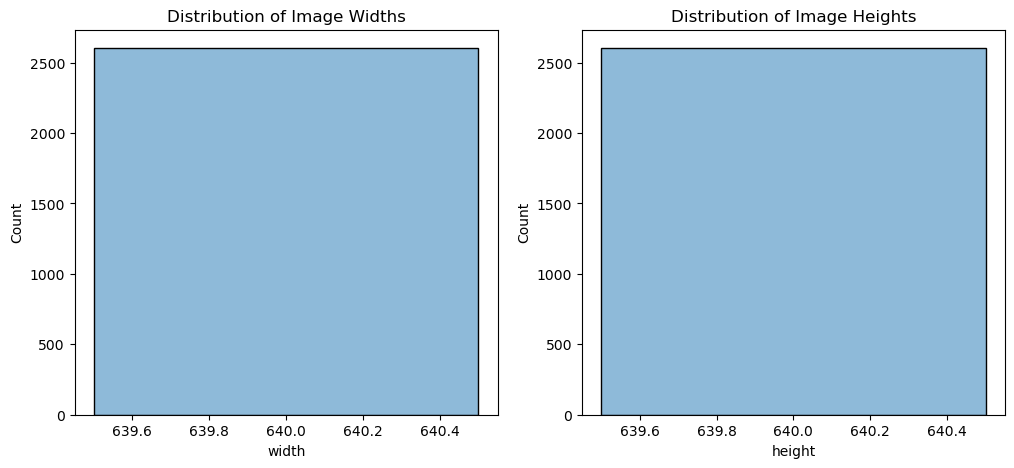

In [8]:
image_sizes = []
for filename in train_df['filename']:
    img_path = os.path.join(directory_path, filename)  # Assuming a directory path is set
    img = Image.open(img_path)
    image_sizes.append(img.size)  # size is a tuple (width, height)

# Convert list of sizes to a DataFrame for analysis
size_df = pd.DataFrame(image_sizes, columns=['width', 'height'])

# Plotting distributions of image widths and heights
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(size_df['width'], kde=True)
plt.title('Distribution of Image Widths')

plt.subplot(1, 2, 2)
sns.histplot(size_df['height'], kde=True)
plt.title('Distribution of Image Heights')
plt.show()

# Create Image Dataset

In [9]:
def apply_transforms(transform, image):
    return transform(image=image)['image']

class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, is_train = 1):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if self.is_train :
            img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
            image = Image.open(img_name)
            target = self.annotations.iloc[idx, 1:].values.astype(float)  # Convert to NumPy array

            if self.transform:
                image = np.array(image)
                image = apply_transforms(self.transform, image)

            # Convert target to tensor
            target = torch.tensor(target, dtype=torch.float)

            return image, target
        else:
            img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 1])
            image = Image.open(img_name)
            image = np.array(image)

            if self.transform:
                image = apply_transforms(self.transform, image)

            return image, 0

In [10]:
# Albumentations transformations for training
albu_train_transforms = Compose([
    Resize(256, 256),  # Resize the image to 256x256
    HorizontalFlip(p=0.5),  # Apply horizontal flip with 50% probability
    RandomBrightnessContrast(p=0.2),  # Randomly adjust brightness and contrast with 20% probability
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),  # Randomly shift, scale, and rotate
    GridDistortion(p=0.2),  # Apply grid distortion with 20% probability
    ElasticTransform(p=0.2),  # Apply elastic transform with 20% probability
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
    ToTensorV2()  # Convert the image to PyTorch tensor
])

# Albumentations transformations for testing
albu_test_transforms = Compose([
    Resize(256, 256),  # Resize the image to 256x256
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
    ToTensorV2()  # Convert the image to PyTorch tensor
])

In [11]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_classes = 10
learning_rate = 5e-4
batch_size = 32
num_epochs = 1

In [12]:
# Create train and test datasets
train_dataset = ImageDataset(csv_file='Train.csv', 
                             root_dir='data/train', 
                             transform=albu_train_transforms)

test_dataset = ImageDataset(csv_file='Test.csv', 
                            root_dir='data/test', 
                            transform=albu_test_transforms, 
                            is_train=0)

In [13]:
# Splitting the dataset into training and testing

n = len(train_dataset)
train_percentage = 0.8
train_length = int(n * train_percentage)
val_length = n - train_length


# Split the dataset
train_set, val_set = random_split(train_dataset, [train_length, val_length], generator=generator)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True,  num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False,  num_workers=4)

# Trainning

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes= {'train': len(train_set), 'val': len(val_set)}

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, model_name, num_epochs=25, device=torch.device('cuda')):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    losses = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = tqdm(dataloaders[phase], total=len(dataloaders[phase]), desc=f'Epoch {epoch}/{num_epochs - 1} (train)')
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = dataloaders[phase]

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.float())

                    # statistics
                    running_loss += loss.item() * inputs.size(0)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        # Update tqdm progress bar with the current loss
                        data_loader.set_postfix(loss=f'{loss.item():.4f}')

            epoch_loss = running_loss / dataset_sizes[phase]
            losses[phase].append(epoch_loss)

            if phase == 'train':
                scheduler.step()

            print(f'{phase} Loss: {epoch_loss:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation loss: {best_loss:.4f}')

    # Plotting the loss
    plt.figure()
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['val'], label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{model_name}_loss_plot.png')  # Save the plot with model name
    plt.show()

    # Save the best model
    torch.save(best_model_wts, f'{model_name}_best_model.pth')

    return model


In [16]:
# pretrained model Resnet50
model1 = torchvision.models.resnet50(weights="IMAGENET1K_V2").to(device)

# Initially, freeze all parameters
for param in model1.parameters():
    param.requires_grad = False

# Unfreeze the last 3 layers.
# We need to count how many children (major blocks) are in the model
children = list(model1.children())
num_children = len(children)

# Unfreeze the last 3 layers
for i in range(num_children - 3, num_children):
    for param in children[i].parameters():
        param.requires_grad = True

# Replace the fully connected layer for fine-tuning
model1.fc = nn.Sequential(
               nn.Linear(model1.fc.in_features, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, num_classes))

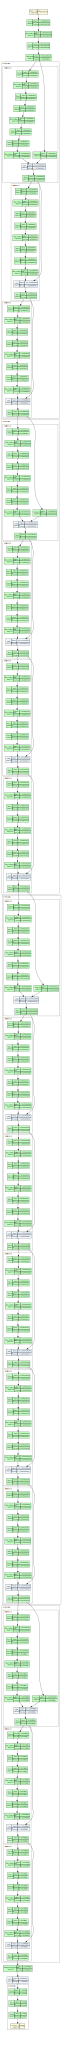

In [17]:
!pip install torchview
from torchview import draw_graph

model_graph = draw_graph(model1, input_size=(1,3,256,256), expand_nested=True)
model_graph.visual_graph

In [18]:
model1 = model1.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_ft = optim.Adam(model1.parameters(), lr=0.001)

# decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)


Epoch 0/9
----------


Epoch 0/9 (train):   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 0/9 (train): 100%|██████████| 82/82 [00:44<00:00,  1.83it/s, loss=0.5646]

train Loss: 0.6131


val Loss: 0.4088

Epoch 1/9
----------


Epoch 1/9 (train): 100%|██████████| 82/82 [00:41<00:00,  1.99it/s, loss=0.4069]

train Loss: 0.4670


val Loss: 0.3031

Epoch 2/9
----------


Epoch 2/9 (train): 100%|██████████| 82/82 [00:41<00:00,  1.96it/s, loss=0.2886]

train Loss: 0.3870


val Loss: 0.2671

Epoch 3/9
----------


Epoch 3/9 (train): 100%|██████████| 82/82 [00:40<00:00,  2.00it/s, loss=0.3156]

train Loss: 0.3376


val Loss: 0.2391

Epoch 4/9
----------


Epoch 4/9 (train): 100%|██████████| 82/82 [00:41<00:00,  2.00it/s, loss=0.2669]


train Loss: 0.3016
val Loss: 0.2043

Epoch 5/9
----------


Epoch 5/9 (train): 100%|██████████| 82/82 [00:42<00:00,  1.93it/s, loss=0.2557]

train Loss: 0.2418


val Loss: 0.1638

Epoch 6/9
----------


Epoch 6/9 (train): 100%|██████████| 82/82 [00:41<00:00,  1.96it/s, loss=0.1129]

train Loss: 0.2181


val Loss: 0.1435

Epoch 7/9
----------


Epoch 7/9 (train): 100%|██████████| 82/82 [00:43<00:00,  1.88it/s, loss=0.0990]

train Loss: 0.1996


val Loss: 0.1420

Epoch 8/9
----------


Epoch 8/9 (train): 100%|██████████| 82/82 [00:44<00:00,  1.84it/s, loss=0.1462]

train Loss: 0.1915


val Loss: 0.1328

Epoch 9/9
----------


Epoch 9/9 (train): 100%|██████████| 82/82 [00:40<00:00,  2.02it/s, loss=0.1425]

train Loss: 0.1757


val Loss: 0.1324

Training complete in 8m 39s
Best validation loss: 0.1324


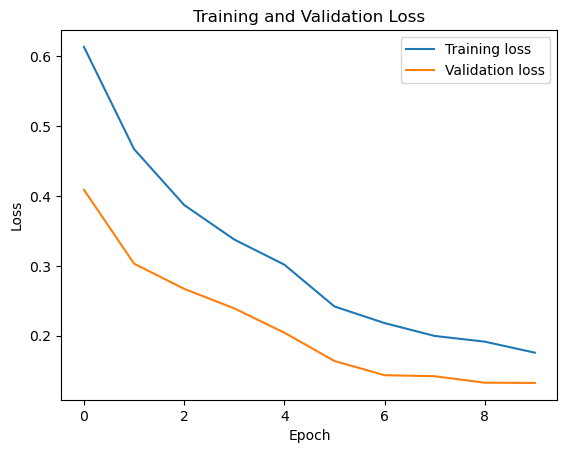

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
train_model(model1, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, "resnet", num_epochs=10, device=torch.device('cuda'))

In [20]:
# Create EfficientNetV2 model
model2 = timm.create_model('efficientnet_b2', pretrained=True)

# Modify the final fully connected layer
model2.classifier = nn.Linear(model2.classifier.in_features, num_classes)

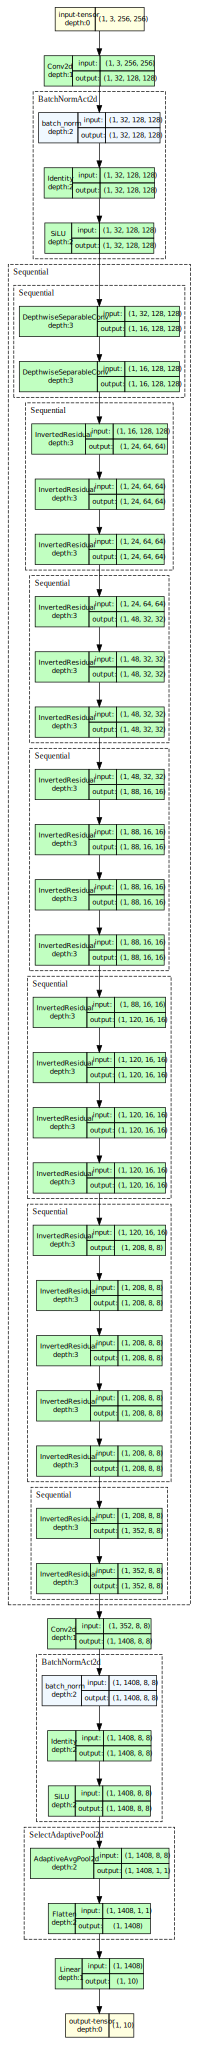

In [21]:
model_graph = draw_graph(model2, input_size=(1,3,256,256), expand_nested=True)
model_graph.visual_graph

Epoch 0/9
----------


Epoch 0/9 (train):   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 0/9 (train): 100%|██████████| 82/82 [00:41<00:00,  1.98it/s, loss=0.4673]

train Loss: 0.6313


val Loss: 0.3859

Epoch 1/9
----------


Epoch 1/9 (train): 100%|██████████| 82/82 [00:41<00:00,  1.96it/s, loss=0.3444]

train Loss: 0.4834


val Loss: 0.3182

Epoch 2/9
----------


Epoch 2/9 (train): 100%|██████████| 82/82 [00:41<00:00,  2.00it/s, loss=0.4916]

train Loss: 0.4139


val Loss: 0.2595

Epoch 3/9
----------


Epoch 3/9 (train): 100%|██████████| 82/82 [00:42<00:00,  1.91it/s, loss=0.3254]

train Loss: 0.3574


val Loss: 0.2250

Epoch 4/9
----------


Epoch 4/9 (train): 100%|██████████| 82/82 [00:40<00:00,  2.04it/s, loss=0.3580]

train Loss: 0.3116


val Loss: 0.1895

Epoch 5/9
----------


Epoch 5/9 (train): 100%|██████████| 82/82 [00:46<00:00,  1.78it/s, loss=0.3311]

train Loss: 0.2340


val Loss: 0.1315

Epoch 6/9
----------


Epoch 6/9 (train): 100%|██████████| 82/82 [00:41<00:00,  1.99it/s, loss=0.2544]

train Loss: 0.1857


val Loss: 0.1216

Epoch 7/9
----------


Epoch 7/9 (train): 100%|██████████| 82/82 [00:43<00:00,  1.90it/s, loss=0.1837]

train Loss: 0.1680


val Loss: 0.0983

Epoch 8/9
----------


Epoch 8/9 (train): 100%|██████████| 82/82 [00:41<00:00,  1.99it/s, loss=0.1638]

train Loss: 0.1484


val Loss: 0.0858

Epoch 9/9
----------


Epoch 9/9 (train): 100%|██████████| 82/82 [00:42<00:00,  1.94it/s, loss=0.1121]

train Loss: 0.1375


val Loss: 0.0771

Training complete in 8m 35s
Best validation loss: 0.0771


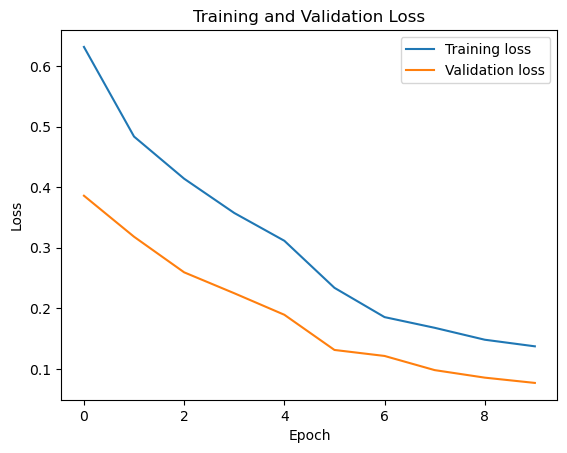

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
      

In [22]:
model2 = model2.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_ft = optim.Adam(model2.parameters(), lr=0.001)

# decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
train_model(model2, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, "eefficientnet", num_epochs=10, device=torch.device('cuda'))

In [45]:
model3=timm.create_model('densenet121', pretrained=True)
# Modify the final fully connected layer
model3.classifier = nn.Linear(model3.classifier.in_features, num_classes)

Epoch 0/14
----------


Epoch 0/14 (train):   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 0/14 (train): 100%|██████████| 82/82 [00:45<00:00,  1.81it/s, loss=0.5074]

train Loss: 0.6711


val Loss: 0.4912

Epoch 1/14
----------


Epoch 1/14 (train): 100%|██████████| 82/82 [00:43<00:00,  1.90it/s, loss=0.4538]

train Loss: 0.5700


val Loss: 0.4661

Epoch 2/14
----------


Epoch 2/14 (train): 100%|██████████| 82/82 [00:42<00:00,  1.92it/s, loss=0.3827]

train Loss: 0.5207


val Loss: 0.3759

Epoch 3/14
----------


Epoch 3/14 (train): 100%|██████████| 82/82 [00:42<00:00,  1.91it/s, loss=0.4336]

train Loss: 0.4693


val Loss: 0.3463

Epoch 4/14
----------


Epoch 4/14 (train): 100%|██████████| 82/82 [00:43<00:00,  1.89it/s, loss=0.3821]

train Loss: 0.4470


val Loss: 0.3225

Epoch 5/14
----------


Epoch 5/14 (train): 100%|██████████| 82/82 [00:42<00:00,  1.95it/s, loss=0.2912]

train Loss: 0.3755


val Loss: 0.2598

Epoch 6/14
----------


Epoch 6/14 (train): 100%|██████████| 82/82 [00:42<00:00,  1.94it/s, loss=0.3293]

train Loss: 0.3341


val Loss: 0.2321

Epoch 7/14
----------


Epoch 7/14 (train): 100%|██████████| 82/82 [00:44<00:00,  1.86it/s, loss=0.2514]

train Loss: 0.3159


val Loss: 0.2156

Epoch 8/14
----------


Epoch 8/14 (train): 100%|██████████| 82/82 [00:43<00:00,  1.88it/s, loss=0.2503]

train Loss: 0.2967


val Loss: 0.2037

Epoch 9/14
----------


Epoch 9/14 (train): 100%|██████████| 82/82 [00:43<00:00,  1.91it/s, loss=0.2551]

train Loss: 0.2860


val Loss: 0.1946

Epoch 10/14
----------


Epoch 10/14 (train): 100%|██████████| 82/82 [00:41<00:00,  1.99it/s, loss=0.1555]

train Loss: 0.2673


val Loss: 0.1962

Epoch 11/14
----------


Epoch 11/14 (train): 100%|██████████| 82/82 [00:40<00:00,  2.02it/s, loss=0.2958]

train Loss: 0.2695


val Loss: 0.1992

Epoch 12/14
----------


Epoch 12/14 (train): 100%|██████████| 82/82 [00:41<00:00,  1.98it/s, loss=0.2662]

train Loss: 0.2641


val Loss: 0.1959

Epoch 13/14
----------


Epoch 13/14 (train): 100%|██████████| 82/82 [00:41<00:00,  1.95it/s, loss=0.1979]

train Loss: 0.2638


val Loss: 0.1861

Epoch 14/14
----------


Epoch 14/14 (train): 100%|██████████| 82/82 [00:39<00:00,  2.06it/s, loss=0.2096]

train Loss: 0.2565


val Loss: 0.1816

Training complete in 12m 60s
Best validation loss: 0.1816


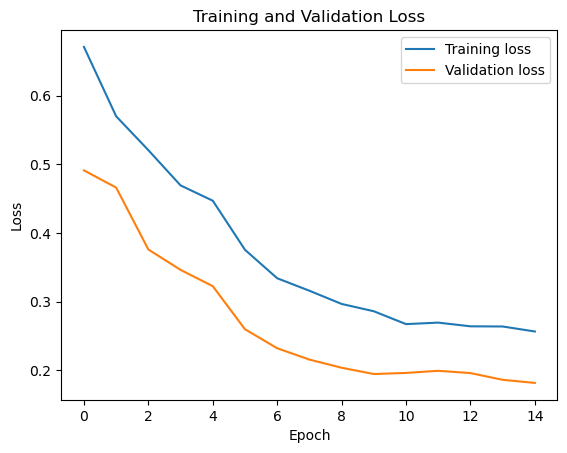

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNormAct2d(
      64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): DenseBlock(
      (denselayer1): DenseLayer(
        (norm1): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
  

In [47]:
model3 = model3.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_ft = optim.Adam(model3.parameters(), lr=0.001)

# decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
train_model(model3, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, "densenet121", num_epochs=15, device=torch.device('cuda'))

In [25]:
# Create the ResNeXt model
model4 = timm.create_model('resnext50_32x4d', pretrained=True)
# Initially, freeze all parameters
for param in model4.parameters():
    param.requires_grad = False

# Unfreeze the last 3 layers.
# We need to count how many children (major blocks) are in the model
children = list(model4.children())
num_children = len(children)

# Unfreeze the last 3 layers
for i in range(num_children - 3, num_children):
    for param in children[i].parameters():
        param.requires_grad = True

# Replace the fully connected layer for fine-tuning
model4.fc = nn.Sequential(
               nn.Linear(model4.fc.in_features, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, num_classes))

Epoch 0/9
----------


Epoch 0/9 (train):   0%|          | 0/82 [00:00<?, ?it/s]

Epoch 0/9 (train): 100%|██████████| 82/82 [00:41<00:00,  1.96it/s, loss=0.5126]

train Loss: 0.6733


val Loss: 0.4501

Epoch 1/9
----------


Epoch 1/9 (train): 100%|██████████| 82/82 [00:42<00:00,  1.94it/s, loss=0.3911]

train Loss: 0.5361


val Loss: 0.3572

Epoch 2/9
----------


Epoch 2/9 (train): 100%|██████████| 82/82 [00:41<00:00,  2.00it/s, loss=0.4115]

train Loss: 0.4378


val Loss: 0.2785

Epoch 3/9
----------


Epoch 3/9 (train): 100%|██████████| 82/82 [00:45<00:00,  1.81it/s, loss=0.2790]

train Loss: 0.3787


val Loss: 0.2556

Epoch 4/9
----------


Epoch 4/9 (train): 100%|██████████| 82/82 [00:42<00:00,  1.95it/s, loss=0.3136]

train Loss: 0.3241


val Loss: 0.2067

Epoch 5/9
----------


Epoch 5/9 (train): 100%|██████████| 82/82 [00:43<00:00,  1.90it/s, loss=0.2149]

train Loss: 0.2651


val Loss: 0.1736

Epoch 6/9
----------


Epoch 6/9 (train): 100%|██████████| 82/82 [00:41<00:00,  1.95it/s, loss=0.1337]

train Loss: 0.2421


val Loss: 0.1604

Epoch 7/9
----------


Epoch 7/9 (train): 100%|██████████| 82/82 [00:42<00:00,  1.95it/s, loss=0.2873]

train Loss: 0.2268


val Loss: 0.1517

Epoch 8/9
----------


Epoch 8/9 (train): 100%|██████████| 82/82 [00:41<00:00,  1.96it/s, loss=0.1440]

train Loss: 0.2223


val Loss: 0.1524

Epoch 9/9
----------


Epoch 9/9 (train): 100%|██████████| 82/82 [00:40<00:00,  2.01it/s, loss=0.2602]

train Loss: 0.2090


val Loss: 0.1375

Training complete in 8m 36s
Best validation loss: 0.1375


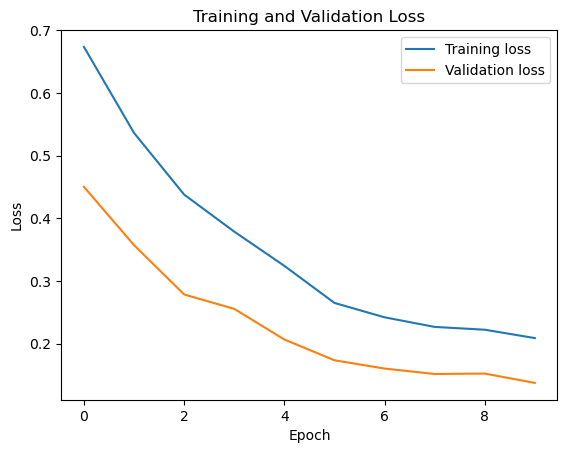

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

In [27]:
model4 = model4.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_ft = optim.Adam(model4.parameters(), lr=0.001)

# decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
train_model(model4, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, "resnext50", num_epochs=10, device=torch.device('cuda'))

# Predictions

In [28]:
def predict_probabilities(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_probabilities = []

    with torch.no_grad():  # Disable gradient tracking
        for data, _ in test_loader:
            data = data.to(device)

            # Forward pass
            outputs = model(data)

            # Apply sigmoid to get probabilities
            probabilities = torch.sigmoid(outputs)

            # Collect probabilities
            all_probabilities.append(probabilities.cpu().numpy())

    #  concatenate all probabilities
    all_probabilities = np.concatenate(all_probabilities, axis=0)

    return all_probabilities

# Model Ensembling

In [37]:
test_dataset = ImageDataset(csv_file='Test.csv', 
                            root_dir='/export/livia/home/vision/Mkdayem/nadhem/miniconda3/envs/myenv/data/test', 
                            transform=albu_test_transforms, 
                            is_train=0)

In [38]:
# Use the function to get probability predictions

probability_predictions1 = predict_probabilities(model1, test_loader, device)
probability_predictions2 = predict_probabilities(model2, test_loader, device)
probability_predictions3 = predict_probabilities(model3, test_loader, device)
probability_predictions4 = predict_probabilities(model4, test_loader, device)

In [39]:
average_predictions = (probability_predictions1 + probability_predictions2 + probability_predictions3+ probability_predictions4) / 4.0

In [40]:
average_predictions

array([[0.9999324 , 0.01993773, 0.19570251, ..., 0.09437185, 0.26439387,
        0.04400819],
       [0.5028399 , 0.01429238, 0.16188034, ..., 0.06443056, 0.9998847 ,
        0.2830035 ],
       [0.15686053, 0.9999071 , 0.99498737, ..., 0.15733284, 0.16307877,
        0.0737142 ],
       ...,
       [0.14054659, 0.02690321, 0.23319194, ..., 0.39284483, 0.9999793 ,
        0.05666548],
       [0.1214526 , 0.99994683, 0.98598295, ..., 0.12962878, 0.1550481 ,
        0.0232595 ],
       [0.10099798, 0.99954057, 0.9942777 , ..., 0.09079179, 0.2583584 ,
        0.01015023]], dtype=float32)

In [41]:
ss=pd.read_csv('/export/livia/home/vision/Mkdayem/nadhem/miniconda3/envs/myenv/SampleSubmission.csv')
ss.iloc[:,1:] = average_predictions

# Submission

In [42]:
ss.to_csv('submission2.csv', index=False)